In [1]:
import pandas as pd
import numpy as np
import pyprind
import time

from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold

from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

from sklearn.neighbors.kde import KernelDensity

Recommender System using SVD and surprise. Of note is that because the imbalance-learn docs were down, I wrote my own over sample and under sample functions. I did not do much grid search on hyperparameters because my computer broke, but it seems any improvements were marginal. Five factors generated an RMSE of 1.036. 200 was 0.98.

I've heard SVD is vulnerable to isolates, items or users which only appear a handful of times. I was going to remove isolates, but didn't have a chance.

In [2]:
df = pd.read_csv('data/11-5 rating info.csv')
df.head()

,userid,hash,rating
0,11372510,hash_8f7ea87f7746be2d042922c4b6483b34,5
1,11372510,hash_f57931482c0c195419bd28f9dbe8c842,5
2,11372510,hash_2dae8e1654f0cf61d75fa18e111c4e09,5
3,11372510,hash_5bd85c2822bd8348a723ae8c62986e00,5
4,11372510,hash_55c685e96da65e70bcec21d46cdf8220,4


In [3]:
len(df)

1200554

In [4]:
user_greater_than_five = df.userid.value_counts()>5

user_greater_than_five = pd.DataFrame(user_greater_than_five)
user_greater_than_five.rename({'userid':'user_gr_5'}, inplace=True, axis=1)
user_greater_than_five.head()
df2 = df.join(user_greater_than_five, on='userid')

In [7]:
item_greater_than_five = df.hash.value_counts()>5

item_greater_than_five = pd.DataFrame(item_greater_than_five)
item_greater_than_five.rename({'hash':'item_gr_5'}, inplace=True, axis=1)
item_greater_than_five.head()
df2 = df2.join(item_greater_than_five, on='hash')

In [8]:
df2.sample(20)

,userid,hash,rating,user_gr_5,item_gr_5
150689,2158493,hash_c63d2b57d1b91a3f17dde0d33e86ea63,3,True,False
523780,123663,hash_215ed450ecc48d2c33fccbb24aa8b879,3,True,True
767060,4805644,hash_8cad195b13e3fc8a77ece49b47436e00,4,True,False
426696,21065290,hash_f22327801a6812bb1edaf95278284537,3,True,True
993169,7935992,hash_73be6b9e26064c1ef9b5c5cd72d68fbf,3,True,False
1054067,11477404,hash_9e01f1971c64050337f9f064bd6872a4,5,True,True
493416,1200744,hash_56ccae697b12918637b32973d641079f,5,True,False
42881,2644953,hash_0a640b9ce15c6fd908b7d7459ded7b1d,4,True,False
161383,117889,hash_7670dc4fd02e1385ac18da849cef8313,4,True,False
50211,1027031,hash_b7b3d5b72d2b26e815002ce313d63b52,5,True,True


In [9]:
print(len(df2))
df2 = df2[df2.user_gr_5]
print(len(df2))
df2 =df2[df2.item_gr_5]
print(len(df2))

1200554
1199444
642127


In [10]:
def random_undersample(df, target):
    new_df = pd.DataFrame()
    
    min_val = min(df[target].value_counts())
    for label in df[target].unique():
        undersample = df[df[target]==label].sample(min_val)
        new_df =  pd.concat([new_df, undersample])
    return new_df

def random_oversample(df, target):
    new_df = pd.DataFrame()
    
    max_val = max(df[target].value_counts())
    for label in df[target].unique():
        oversample = df[df[target]==label].sample(max_val, replace=True)
        new_df =  pd.concat([new_df, oversample])
    return new_df

In [11]:
osdf = random_oversample(df2, 'rating')
usdf = random_undersample(df2, 'rating')

In [12]:
osdf.rating.value_counts()

5    243740
4    243740
3    243740
2    243740
1    243740
Name: rating, dtype: int64

In [13]:
len(osdf)

1218700

In [14]:
osdf.head()

,userid,hash,rating,user_gr_5,item_gr_5
596000,13091599,hash_9ff2134c486dd6322b3aef7ab12efb0f,5,True,True
60014,1232712,hash_112bc79b1dc857cc2c2cbe019675c77f,5,True,True
405092,25480373,hash_e812653c6879b61017cfe7804243ad19,5,True,True
1052861,20356481,hash_460a484dede9f071acf4e19c9f099832,5,True,True
326158,20199767,hash_f66e59320d1a4f73551b44ddccd8e009,5,True,True


In [16]:
data = osdf[['userid', 'hash', 'rating']]

In [17]:
data = Dataset.load_from_df(data, reader=Reader(rating_scale=(1, 5)))

In [22]:
algo = SVD(lr_all=0.005, reg_all = 0.0001, n_factors=200)

kf = KFold(n_splits=3)

algo = SVD()

for trainset, testset in kf.split(data):
    t0 = time.time()
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)
    t1 = time.time()
    print(t1-t0)


RMSE: 0.5703
64.84171462059021
RMSE: 0.5729
56.4178900718689
RMSE: 0.5711
56.51608204841614


In [23]:
algo2 = SVD(lr_all=0.005, reg_all = 0.01, n_factors=1)

kf = KFold(n_splits=3)

for trainset, testset in kf.split(data):
    t0 = time.time()
    # train and test algorithm.
    algo2.fit(trainset)
    predictions = algo2.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)
    t1 = time.time()
    print(t1-t0)

RMSE: 1.0297
19.262367248535156
RMSE: 1.0311
21.32308053970337
RMSE: 1.0292
23.0701904296875


In [19]:
algo3 = SVD(lr_all=0.005, reg_all = 0.01, n_factors=40)

kf = KFold(n_splits=3)

for trainset, testset in kf.split(data):
    t0 = time.time()
    # train and test algorithm.
    algo3.fit(trainset)
    predictions = algo3.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)
    t1 = time.time()
    print(t1-t0)

RMSE: 0.6437
44.53495264053345
RMSE: 0.6422
44.53831243515015
RMSE: 0.6440
48.853729009628296


In [84]:
# from surprise.model_selection import GridSearchCV

# param_grid = {'n_epochs': [10], 'lr_all': [0.002, 0.005, 0.01],
#               'reg_all': [0.0001, 0.01, 0.1, 1, 10],
#               'n_factors': [1, 5, 10, 50, 100, 200]}

# gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=1)

# gs.fit(trainset)

AttributeError: 'Trainset' object has no attribute 'raw_ratings'

In [20]:
progbar = pyprind.ProgBar(len(algo3.qi))

items = []

for i in range(len(algo3.qi)):
    items.append(([trainset.to_raw_iid(i), algo3.bi[i]] + list(algo3.qi[i])))
    progbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [21]:
df_items = pd.DataFrame(items)
df_items.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,hash_66bd251f2d18ce183d18bd387d2e973d,-0.172930,-0.028103,-0.223460,-0.035469,0.113486,0.049002,0.120683,-0.214678,-0.107820,...,0.013351,-0.036024,0.085505,-0.184906,-0.011864,-0.118992,-0.021779,-0.172343,-0.062204,0.165561
1,hash_8466618ac1ae058828011a26e7b5e60f,0.208797,-0.024963,0.046442,-0.656345,-0.158792,-0.083407,0.035388,0.587255,0.134119,...,0.759217,-0.737455,-0.100480,0.348089,0.324024,0.216771,-0.451586,0.245189,0.100525,-0.454094
2,hash_87ca483b2e90f93980ee25df09eacf99,0.638755,-0.256699,0.306707,-0.057934,0.466045,0.164737,-0.191644,0.289071,-0.661782,...,-0.574859,-0.269398,0.292238,0.178438,-0.153396,-0.169998,-0.162705,0.238297,-0.275924,-0.279752
3,hash_2032bf9577b6c4791aa1e00926f7aafd,0.813292,-0.427983,0.464713,-0.430439,0.049712,-0.403589,0.494130,0.576196,-0.027051,...,-0.048657,0.074584,-0.075561,0.226364,-0.285634,-0.236753,0.191464,0.025262,-0.402932,-0.032671
4,hash_f33c29ef8819e13f557be54a10d2e6c3,0.023426,-0.180042,0.322995,-0.159424,-0.331475,0.173746,-0.114023,0.307676,0.226467,...,-0.075873,-0.106311,0.024278,-0.221217,-0.007434,-0.065817,-0.560487,-0.271060,0.227242,-0.076418


In [22]:
progbar = pyprind.ProgBar(len(algo3.pu))

users = []

for i in range(len(algo3.qi)):
    users.append(([trainset.to_raw_uid(i), algo3.bi[i]] + list(algo3.pu[i])))
    progbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


ValueError: 3404 is not a valid inner id.

In [23]:
df_users=pd.DataFrame(users)

In [24]:
df_users.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,16668577,-0.172930,0.280011,0.439758,0.660478,-0.309844,0.656198,0.344646,1.102115,0.202402,...,0.555684,0.066521,0.044912,-0.175854,0.015970,0.233702,-0.261740,-0.559784,0.316549,-0.491456
1,2800966,0.208797,-0.278394,-0.066314,0.587049,-0.159017,0.284405,0.793486,0.008937,-1.123458,...,-0.751662,-0.613535,-0.755424,0.410528,0.379541,-0.035804,0.471862,-0.365903,0.482529,0.161844
2,12637284,0.638755,-0.012601,-0.055559,0.047078,0.693144,0.520639,-0.303764,0.515127,0.657705,...,0.253663,-0.007694,-0.055404,-0.261422,0.262371,0.012137,0.075919,-0.066541,0.245350,-0.223611
3,31195574,0.813292,-0.012263,0.382312,0.246031,-0.291908,0.495820,-0.583138,-0.233677,0.365359,...,-0.195080,0.241371,-0.010458,0.078238,-0.054601,0.220472,-0.017766,0.475160,-0.120634,1.326613
4,280423,0.023426,-0.294836,-0.139491,0.118666,0.124858,-0.261158,-0.087790,-0.067027,0.093638,...,-0.012560,-0.435986,-0.131153,0.194284,-0.143605,-0.084700,-0.103136,0.138459,-0.320347,-0.372101


I realized that the distribution of predicted ratings is normal, and so can be described by a mean and standard deviation.  This takes about 3 hours to run, and probably could be vectorized.  I just let it run overnight.

In [33]:
test_book = np.array(df_items.loc[1])
bi = test_book[1]
qi = test_book[2:]
ratings = []
t0 = time.time()
for row in df_users.itertuples():
    bu = row[2]
    pu = np.array(row[3:])
    rating = bi+ bu + np.dot(qi, pu)
    ratings.append(rating)
ratings = np.array(ratings)
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(ratings.reshape(-1, 1))
t1 = time.time()
print(t1-t0)

test_book

kde.sample()

ratings[0:10]

kde.score_samples(np.array(0).reshape(1, -1))

print(np.mean(ratings))

print(np.std(ratings))

%matplotlib inline
import seaborn as sns
sns.distplot(ratings)




0.10150265693664551
-0.48492517479485997
0.4775352798266684


ModuleNotFoundError: No module named 'seaborn'

0.03650689125061035
-1.6173707535025323
0.8905437103884728


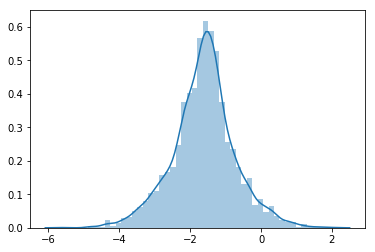

In [185]:
test_book = np.array(df_items.loc[100])
bi = test_book[1]
qi = test_book[2:]
ratings = []
t0 = time.time()
for row in df_users.itertuples():
    bu = row[2]
    pu = np.array(row[3:])
    rating = bi+ bu + np.dot(qi, pu)
    ratings.append(rating)
ratings = np.array(ratings)
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(ratings.reshape(-1, 1))
t1 = time.time()
print(t1-t0)

test_book

kde.sample()

ratings[0:10]

kde.score_samples(np.array(0).reshape(1, -1))

print(np.mean(ratings))

print(np.std(ratings))

%matplotlib inline
import seaborn as sns
sns.distplot(ratings)




In [26]:
df_items.to_csv('data/11-5 book factor.csv')

In [27]:
df_users.to_csv('data/11-5 user factor.csv')

KernelDensity(algorithm='auto', atol=0, bandwidth=0.2, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

ValueError: Expected 2D array, got scalar array instead:
array=1.0.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.